# Train LTSM model with time series data

Problem: predict lap time D laps in the future in a new event based on the historical event data.

In this experiment, we treat the lap time info for each car a time series and bulid lstm model on it.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
import time
from sklearn.preprocessing import MinMaxScaler
# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"
from indycar.notebook import *

Using TensorFlow backend.


### Load data and Initialization

In [2]:
# predict D lap in the future
D = 5 
# hidden utnits for LSTM
hunits = 16

In [3]:
#datalist = ['2017-all_completed_laps_diff.csv','2018-all_completed_laps_diff.csv' ]

#datalist = read_list('train_all.list')
datalist = read_list('train_completed.list')
scaler, dataset, dblens = load_data(datalist)

dataset.info(verbose=True)
print('dataset shape', dataset.shape)

load data/Barber-2018-completed_laps_diff.csv, len=797
load data/Gateway-2018-completed_laps_diff.csv, len=1992
load data/Indy500-2017-completed_laps_diff.csv, len=3216
load data/IndyGP-2018-completed_laps_diff.csv, len=1806
load data/Iowa-2018-completed_laps_diff.csv, len=1505
load data/LongBeach-2018-completed_laps_diff.csv, len=1204
load data/Mid-Ohio-2018-completed_laps_diff.csv, len=1274
load data/Phoenix-2018-completed_laps_diff.csv, len=2761
load data/Pocono-2018-completed_laps_diff.csv, len=804
load data/Portland-2018-completed_laps_diff.csv, len=1907
load data/RoadAmerica-2018-completed_laps_diff.csv, len=1008
load data/StPete-2018-completed_laps_diff.csv, len=1554
load data/Texas-2018-completed_laps_diff.csv, len=2241
load data/Toronto-2018-completed_laps_diff.csv, len=1290
load data/Indy500-2018-completed_laps_diff.csv, len=3618
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26977 entries, 0 to 3617
Data columns (total 8 columns):
Unnamed: 0        26977 non-null int64
ca

In [4]:
# generate train/test dataset

# post-padding with 0
X, y, w = generate_data(dataset, D=D, target='time')

total = np.sum(dblens)
ntrain = np.sum(dblens[:-1])
nval = int(dblens[-1] / 2)
print('train=%d, val=%d, test=%d'%(ntrain, nval, total-ntrain-nval))

X_train, X_val, X_test = X[:ntrain], X[ntrain:ntrain + nval], X[ntrain + nval:]
y_train, y_val, y_test = y[:ntrain], y[ntrain:ntrain + nval], y[ntrain + nval:]
#weights
w_train, w_val, w_test = w[:ntrain], w[ntrain:ntrain + nval], w[ntrain+nval:]
print('train shape:', X_train.shape)

carNumber = 200, max T =301
train=182, val=9, test=9
train shape: (182, 296, 1)


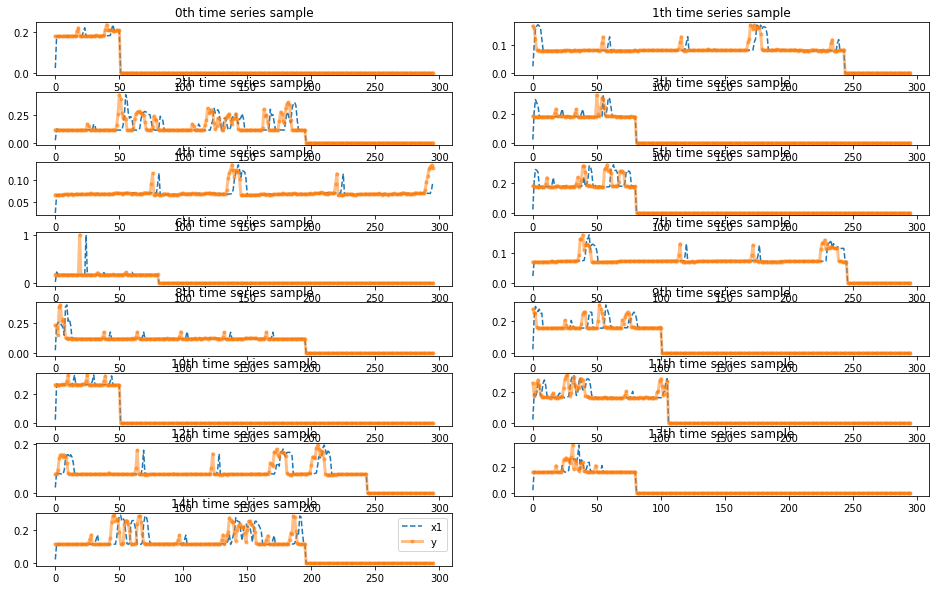

In [5]:
#
# plot one car time series for each event
#
firstcar = np.cumsum(dblens)
idx = [0]
idx.extend(list(firstcar)[:-1])
plot_examples(X[idx],y[idx],ypreds=None,nm_ypreds=None)
#plot_examples(X[:10],y[:10],ypreds=None,nm_ypreds=None)

## Define model

In [6]:
#
# https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
#
def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    #model.compile(loss="mean_squared_error",
    #              sample_weight_mode="temporal",
    #              optimizer="rmsprop")
    
    model.compile(loss="mean_absolute_error",
                  sample_weight_mode="temporal",
                  optimizer="adam")
    
    return(model,(inp,rnn,dens))

In [7]:

model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 296, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 296, 16)           1152      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 296, 1)            17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


### train for 500 epochs



Time Took :11.87 min


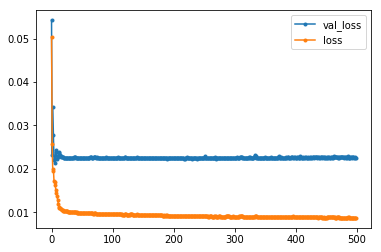

In [8]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=32,
                             shuffle=True,
                             epochs=500,
                             verbose=0,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))
for line in history.history.keys():
    plt.plot(history.history[line],marker='.',label=line)
plt.legend()

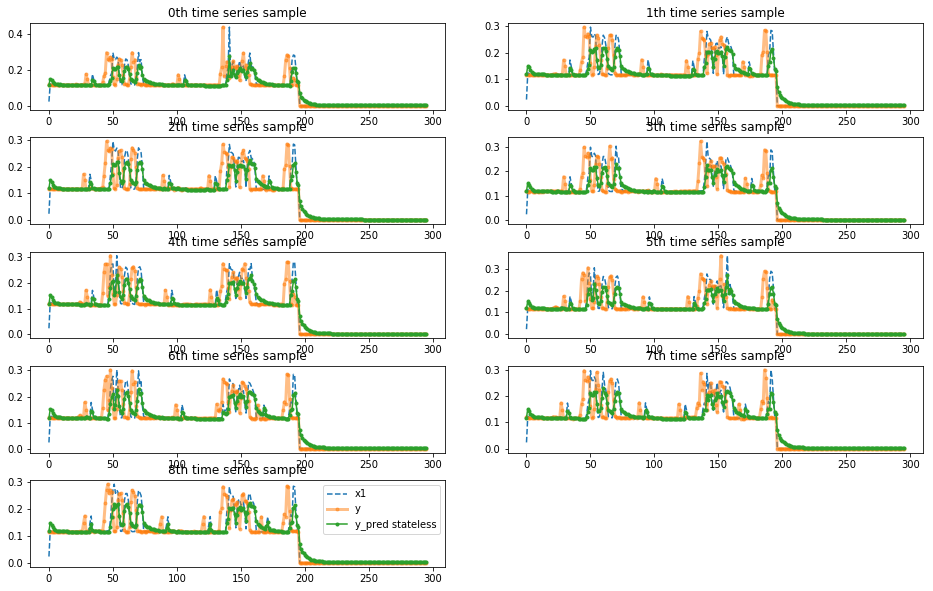

In [12]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

In [11]:
lstmts_result = predict('lstmts', model_stateless, X_test, y_test, scaler)
print(lstmts_result[0][:10])

lstmts model mae=0.023966, raw mae=5.392019, raw mape=12.039039
[0.11803528 0.1512082  0.14446549 0.13344195 0.12642843 0.12338037
 0.12062842 0.11947159 0.11912063 0.11928044]


In [19]:
lstmts_result[0][20:60], y_test[0,20:60].flatten()

(array([0.11638539, 0.11656962, 0.11686633, 0.11608727, 0.11598805,
        0.11677881, 0.11762815, 0.1165043 , 0.11542702, 0.11554007,
        0.11619905, 0.11566739, 0.11676511, 0.11596856, 0.14449683,
        0.13704933, 0.12159518, 0.11783002, 0.11704488, 0.11667089,
        0.11620839, 0.11576194, 0.11545351, 0.11485803, 0.11481121,
        0.11462796, 0.11432807, 0.12250184, 0.1406858 , 0.1530005 ,
        0.21019684, 0.20333962, 0.20550498, 0.2163449 , 0.21691324,
        0.17179015, 0.14548936, 0.14043298, 0.1552192 , 0.19401091],
       dtype=float32),
 array([0.11888945, 0.12039819, 0.11779228, 0.11621398, 0.11709358,
        0.11854499, 0.11729048, 0.11990416, 0.11784673, 0.17677009,
        0.14786155, 0.11763872, 0.11587508, 0.11580218, 0.11570862,
        0.11550217, 0.11546328, 0.11569462, 0.11522149, 0.11592997,
        0.11601642, 0.11584641, 0.1329177 , 0.1663938 , 0.18295951,
        0.29718295, 0.260008  , 0.25856192, 0.27230061, 0.26281725,
        0.16239249, 0.11

### train for 2000 epochs
It is amazing to see the capacity of the model, which predicts the pikes of crashes ''accurately''.
However, the performance goes worse in the cases of pitstops. They are totally ignored.
Overfitting must occur here.
To verify that, let''s train on data of a different event, such as train on 2017 and then test on 2018. 
Another idea is to modify the loss funtion to emphysize on pitstops.



In [ ]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=32,
                             shuffle=True,
                             epochs=2000,
                             verbose=0,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))
for line in history.history.keys():
    plt.plot(history.history[line],marker='.',label=line)
plt.legend()

In [ ]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

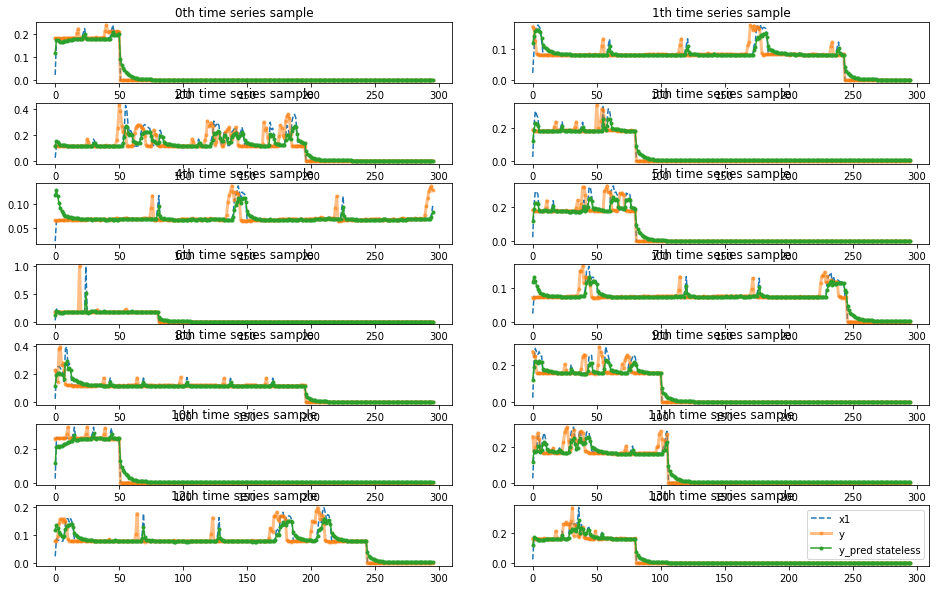

In [16]:
y_pred_stateless = model_stateless.predict(X_train)

idx_train = idx[:-1]

plot_examples(X_train[idx_train],y_train[idx_train],ypreds=[y_pred_stateless[idx_train]],nm_ypreds=["y_pred stateless"])

### conclusion

Obviously, the model capture the crashes in 2017 but failed in predicting what happens in 2018.

As crashes are not ''predictable'', we would like to train a model to capture the pitstops rather than the bigger
spikes caused by the ''random'' crashes.

In the next step, let''s try to modify the loss function to suppress the effects of crashes and emphysize on 
pitstops. After all, the ranking are influenced more by pitstops.
